In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
from PIL import Image

In [26]:
class FlowerDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_filenames = [f for f in sorted(os.listdir(image_dir)) if f.endswith('.jpg')]
        self.labels = self.load_labels(label_file)

        assert len(self.image_filenames) == len(self.labels), "Mismatch between images and labels"

    def load_labels(self, label_file):
        with open(label_file, 'r') as f:
            labels = [int(line.strip()) - 1 for line in f]  # Adjust labels to start at 0
        return labels

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [27]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [28]:
train_dataset = FlowerDataset(image_dir='train_data', label_file='train_labels.txt', transform=train_transform)
val_dataset = FlowerDataset(image_dir='val_data', label_file='val_labels.txt', transform=val_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

In [29]:
model = models.resnet18(pretrained=True)
num_classes = 60

# Replace the fully connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, train_accuracies, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        correct_val, total_val = 0, 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validating"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Accuracy: {val_accuracy:.2f}%")

    return train_losses, train_accuracies, val_accuracies

In [31]:
num_epochs = 10
train_losses, train_accuracies, val_accuracies = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

Validating: 100%|██████████| 38/38 [00:19<00:00,  1.97it/s]


Epoch [1/10] - Train Loss: 3.2730, Train Accuracy: 19.63%, Val Accuracy: 28.67%


Validating: 100%|██████████| 38/38 [00:20<00:00,  1.89it/s]


Epoch [2/10] - Train Loss: 2.3682, Train Accuracy: 36.57%, Val Accuracy: 34.17%


Validating: 100%|██████████| 38/38 [00:19<00:00,  1.90it/s]


Epoch [3/10] - Train Loss: 1.8550, Train Accuracy: 49.23%, Val Accuracy: 59.67%


Validating: 100%|██████████| 38/38 [00:19<00:00,  1.93it/s]


Epoch [4/10] - Train Loss: 1.5912, Train Accuracy: 56.27%, Val Accuracy: 68.17%


Validating: 100%|██████████| 38/38 [00:19<00:00,  1.91it/s]


Epoch [5/10] - Train Loss: 1.3958, Train Accuracy: 60.63%, Val Accuracy: 69.17%


Validating: 100%|██████████| 38/38 [00:20<00:00,  1.86it/s]


Epoch [6/10] - Train Loss: 1.2548, Train Accuracy: 65.60%, Val Accuracy: 77.33%


Validating: 100%|██████████| 38/38 [00:20<00:00,  1.82it/s]


Epoch [7/10] - Train Loss: 1.1199, Train Accuracy: 69.57%, Val Accuracy: 79.33%


Validating: 100%|██████████| 38/38 [00:20<00:00,  1.87it/s]


Epoch [8/10] - Train Loss: 1.0581, Train Accuracy: 71.50%, Val Accuracy: 79.50%


Validating: 100%|██████████| 38/38 [00:20<00:00,  1.86it/s]


Epoch [9/10] - Train Loss: 1.0108, Train Accuracy: 71.20%, Val Accuracy: 82.67%


Validating: 100%|██████████| 38/38 [00:20<00:00,  1.87it/s]

Epoch [10/10] - Train Loss: 0.8827, Train Accuracy: 75.30%, Val Accuracy: 81.33%


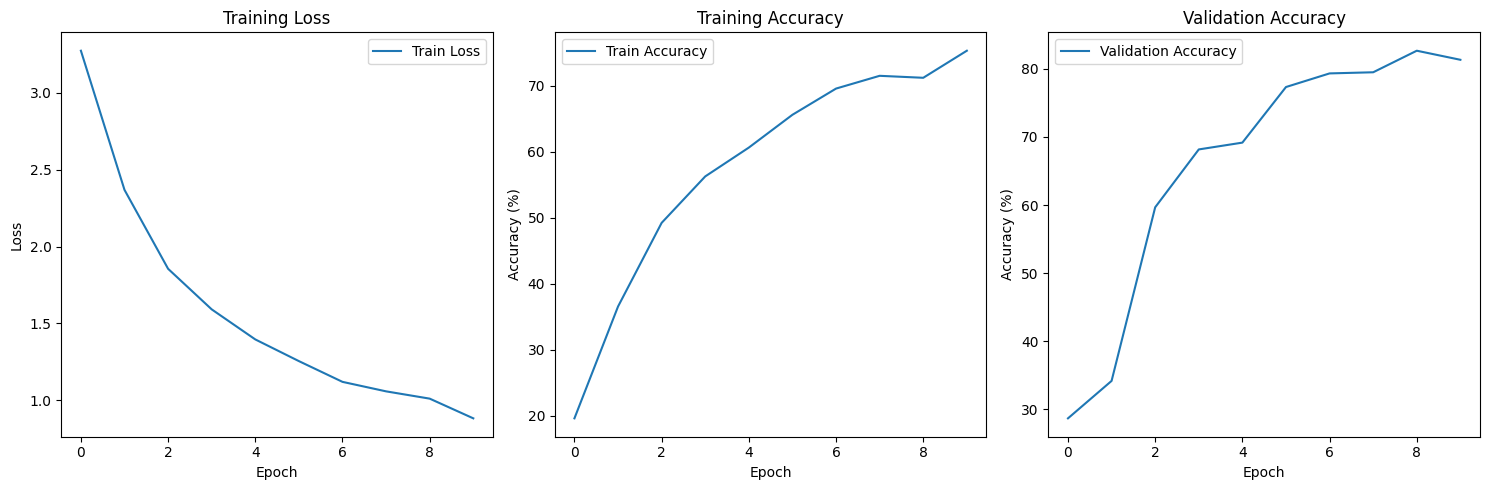

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
test_img_path = "val_data/26_image_04754.jpg" #Enter the absolute image file path to test
test_image = Image.open(test_img_path).convert("RGB")
test_image = transform(test_image).unsqueeze(0)

model.eval()
with torch.no_grad():
    output = model(test_image.to(device))
    _, predicted = torch.max(output, 1)

print(f"The predicted class for the image is: {predicted.item() + 1}")



The predicted class for the image is: 26
